# Beeler Reuter Model - Stimulation
The 1997 Beeler Reuter model of the AP in ventricular myocytes.<br/>
Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1283659/<br/>
Constant: http://docs.myokit.org/_static/guide/br-1977.mmt
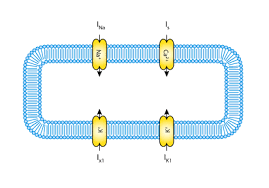

In [1]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
# Cell membrane capacity
C_m = 1 # membrane capacitance (uF/cm^2)

# The fast Sodium current: INa
G_Na_max = 4 # max sodium conductance (mS/cm^2)
G_Na_C = 0.003 # max sodium conductance (mS/cm^2)
E_Na = 50 # sodium Nernst voltage (mV)

E_K = -77 # potassium Nernst voltage (mV)

# The calcium current
G_Ca_max = 0.09 # max sodium conductance (mS/cm^2)

# The Potassium currents

G_K_max = 36 # max potassium conductance (mS/cm^2)

# leakage conductivity
G_L = 0.3 # leakage conductance (mS/cm^2)

V_rest = -84.622 # resting membrane voltage (mV)

# Nernst voltages
E_L = V_rest + 10.6 # leak Nernst voltage (mV)

In [3]:
def calc_gates(V_m):
    #if V_m == -50:
    #    alpha_n = 1
    #else:
    alpha_n = 0.0005 * np.exp(0.083 * (V_m + 50)) / (np.exp(0.057 * (V_m + 50)) + 1)
    beta_n = 0.0013 * np.exp(-0.06 * (V_m + 20)) / (np.exp(-0.04 * (V_m + 333)) + 1)
    
    # Na
    if V_m == -47:
        alpha_m = 1
    else:
        alpha_m = (V_m + 47) / (1 - np.exp(-0.1 * (V_m + 47)))
    beta_m = 40 * np.exp(-0.056 * (V_m + 72))
    
    alpha_h = 0.126 * np.exp(-0.25 * (V_m + 77))
    beta_h = 1.7/(1 + np.exp(-0.082 * (V_m + 22.5)))
    
    if V_m == -78:
        alpha_j = 1
    else:
        alpha_j = 0.055 * np.exp(-0.25 * (V_m + 78)) / (1 + np.exp(-0.2 * (V_m + 78)))
    beta_j = 0.3 / (1 + np.exp(-0.1 * (V_m + 32)))
    
    alpha_d = 0.095 * np.exp(-0.01 * (V_m + -5)) / (np.exp(-0.072 * (V_m + -5)) + 1)
    beta_d  = 0.07 * np.exp(-0.017 * (V_m + 44)) / (np.exp(0.05 * (V_m + 44)) + 1)
    
    alpha_f = 0.012 * np.exp(-0.008 * (V_m + 28)) / (np.exp(0.15 * (V_m + 28)) + 1)
    beta_f  = 0.0065 * np.exp(-0.02 * (V_m + 30)) / (np.exp(-0.2 * (V_m + 30)) + 1)
    
    return (alpha_m, beta_m, alpha_h, beta_h, alpha_j, beta_j, 
            alpha_n, beta_n,
            alpha_d, beta_d, alpha_f, beta_f)

## SImulation Properties

In [4]:
delta_t = 0.01
t_end = 400
timesteps = np.arange(0,t_end, delta_t)

n_timesteps = len(timesteps)

# initial values
n0 = 0.0004

m0 = 0.01
h0 = 0.99
j0 = 0.98

d0 = 0.003
f0 = 0.99
Cai0 = 2e-7

V0 = V_rest

I_stim = 25 # stimulus amplitude (uA/cm^2)
t_stim = 3 # stimulus duration (ms)

## Simulation

In [5]:
# variables
alpha_n = np.zeros((n_timesteps))
beta_n = np.zeros((n_timesteps))

alpha_m = np.zeros((n_timesteps))
beta_m = np.zeros((n_timesteps))
alpha_h = np.zeros((n_timesteps))
beta_h = np.zeros((n_timesteps))
alpha_j = np.zeros((n_timesteps))
beta_j = np.zeros((n_timesteps))

alpha_d = np.zeros((n_timesteps))
beta_d = np.zeros((n_timesteps))
alpha_f = np.zeros((n_timesteps))
beta_f = np.zeros((n_timesteps))

n = np.zeros((n_timesteps))
n_dot = np.zeros((n_timesteps))

m = np.zeros((n_timesteps))
m_dot = np.zeros((n_timesteps))
h = np.zeros((n_timesteps))
h_dot = np.zeros((n_timesteps))
j = np.zeros((n_timesteps))
j_dot = np.zeros((n_timesteps))

d = np.zeros((n_timesteps))
d_dot = np.zeros((n_timesteps))
f = np.zeros((n_timesteps))
f_dot = np.zeros((n_timesteps))

Cai = np.zeros((n_timesteps))
Cai_dot = np.zeros((n_timesteps))

I_Na = np.zeros((n_timesteps))
I_Ca = np.zeros((n_timesteps))
I_X1 = np.zeros((n_timesteps))
I_L = np.zeros((n_timesteps))
I_K1 = np.zeros((n_timesteps))

V_m = np.zeros((n_timesteps))
V_m_dot = np.zeros((n_timesteps))

# initialize
V_m[0] = V0
n[0] = n0
m[0] = m0
h[0] = h0
j[0] = j0
d[0] = d0
f[0] = f0
Cai[0] = Cai0

# iterate
for t_index,t in enumerate(tqdm_notebook(timesteps)):   
    
    # calculate ion gates
    (alpha_m[t_index], beta_m[t_index], 
     alpha_h[t_index], beta_h[t_index], 
     alpha_j[t_index], beta_j[t_index], 
     alpha_n[t_index], beta_n[t_index], 
     alpha_d[t_index], beta_d[t_index], 
     alpha_f[t_index], beta_f[t_index]) = calc_gates(V_m[t_index])

    n_dot[t_index] = alpha_n[t_index] * (1 - n[t_index]) - beta_n[t_index] * n[t_index]
    
    m_dot[t_index] = alpha_m[t_index] * (1 - m[t_index]) - beta_m[t_index] * m[t_index]
    h_dot[t_index] = alpha_h[t_index] * (1 - h[t_index]) - beta_h[t_index] * h[t_index]
    j_dot[t_index] = alpha_j[t_index] * (1 - j[t_index]) - beta_j[t_index] * j[t_index]
    
    d_dot[t_index] = alpha_d[t_index] * (1 - d[t_index]) - beta_d[t_index] * d[t_index]
    f_dot[t_index] = alpha_f[t_index] * (1 - f[t_index]) - beta_f[t_index] * f[t_index]

    if t_index < n_timesteps-1:
        n[t_index+1] = n[t_index] + n_dot[t_index] * delta_t
        
        m[t_index+1] = m[t_index] + m_dot[t_index] * delta_t
        h[t_index+1] = h[t_index] + h_dot[t_index] * delta_t
        j[t_index+1] = j[t_index] + j_dot[t_index] * delta_t
        
        d[t_index+1] = d[t_index] + d_dot[t_index] * delta_t
        f[t_index+1] = f[t_index] + f_dot[t_index] * delta_t

    # The excitatory inward sodium current
    I_Na[t_index] = (V_m[t_index]-E_Na) * (G_Na_max * m[t_index]**3 * h[t_index] * j[t_index] + G_Na_C)
    #I_L[t_index] = (V_m[t_index]-E_L) * G_L
    
    #A voltage- and time-dependent outward current, primarily carried by potassium ions
    I_X1[t_index] = n[t_index] * 0.8 * (np.exp(0.04 * (V_m[t_index] + 77)) - 1) / np.exp(0.04 * (V_m[t_index] + 35))
    
    # A time-independent outward potassium current exhibiting inward-going rectification
    I_K1[t_index] = 0.35 * (
        4 * (np.exp(0.04 * (V_m[t_index] + 85)) - 1)
        / (np.exp(0.08 * (V_m[t_index] + 53)) + np.exp(0.04 * (V_m[t_index] + 53)))
        + 0.2 * (V_m[t_index] + 23)
        / (1 - np.exp(-0.04 * (V_m[t_index] + 23)))
    )
    
    # The slow inward current, primarily carried by calcium ions
    E_Ca = -82.3 - 13.0287 * np.log(Cai[t_index])
    I_Ca[t_index] = G_Ca_max * d[t_index] * f[t_index] * (V_m[t_index] - E_Ca)
    
    Cai_dot[t_index] = -1e-7 * I_Ca[t_index] + 0.07 * (1e-7 - Cai[t_index])
    if t_index < n_timesteps-1:
        Cai[t_index+1] = Cai[t_index] + Cai_dot[t_index] * delta_t
    
    # calcultate membrane voltage change
    V_m_dot[t_index] = - 1/C_m * (I_Na[t_index] + I_K1[t_index] + I_X1[t_index] + I_Ca[t_index])
    if t < t_stim:
        V_m_dot[t_index] += I_stim
    
    # calcultate membrane voltage
    if t_index < n_timesteps-1:
        V_m[t_index+1] = V_m[t_index] + delta_t * V_m_dot[t_index]

## Plot Results

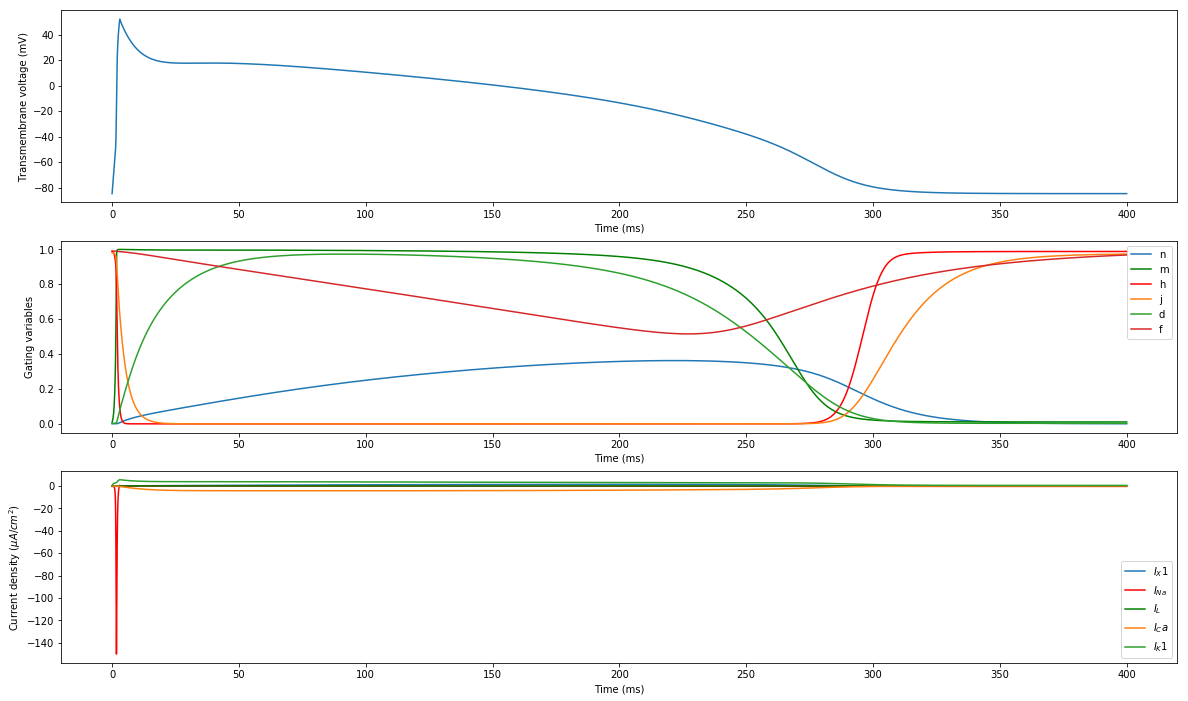

In [6]:
plt.figure(figsize=(20, 12))
plt.subplot(3,1,1)
plt.plot(timesteps,V_m)
plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane voltage (mV)')

plt.subplot(3,1,2)
plt.plot(timesteps,n)
plt.plot(timesteps, m, 'g')
plt.plot(timesteps,h,'r')
plt.plot(timesteps,j)
plt.plot(timesteps,d)
plt.plot(timesteps,f)
plt.legend(['n','m','h', 'j', 'd', 'f'])
plt.xlabel('Time (ms)')
plt.ylabel('Gating variables')

plt.subplot(3,1,3)
plt.plot(timesteps,I_X1)
plt.plot(timesteps, I_Na,'r')
plt.plot(timesteps,I_L,'g')
plt.plot(timesteps,I_Ca)
plt.plot(timesteps,I_K1)
plt.legend(['$I_X1$','$I_{Na}$','$I_L$','$I_Ca$','$I_K1$'])
plt.xlabel('Time (ms)')
plt.ylabel('Current density ($\mu A/cm^2$)')
plt.show()